In [1]:
import re
import pandas as pd
import nltk
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import transformers as ppb
from bertopic import BERTopic
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

1. Estude o notebook “A Visual Notebook to Using BERT for the First Time.ipynb”, anexo a essa lista.<br>
a) Resolva o mesmo problema de classificação da segunda questão da segunda lista, usando uma combinação de DistilBERT com os três classificadores
usados na segunda lista.<br>
b) Compare todos os resultados.

In [2]:
df = pd.read_csv('dataset/hacker_news_sample.csv')
df = df.dropna(subset=['text'])
# remove html symbols
df['text'] = df['text'].apply(lambda row: re.sub('\<[^>]*\>', ' ', row))
df['text'] = df['text'].apply(lambda row: re.sub('\&[^;]*\;', ' ', row))

stop_words = set(nltk.corpus.stopwords.words("english"))

temp = df['text'].apply(lambda row: [x for x in nltk.word_tokenize(row) if x not in stop_words])
df['text'] = temp.apply(lambda x: " ".join(x))

In [3]:
data = df[['text', 'type']][:200]
temp = df[['text', 'type']][200:]
data = pd.concat([data, temp.loc[temp['type'] == 'story']])
# comment -> 0
# story -> 1

y = [0 if i == 'comment' else 1 for i in data['type']]
print(data.shape)
print(y.count(0), y.count(1))

(366, 2)
194 172


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the 

F1 score 0.7126436781609194
recall 0.7560975609756098
precisao 0.6739130434782609
acuracia 0.7282608695652174


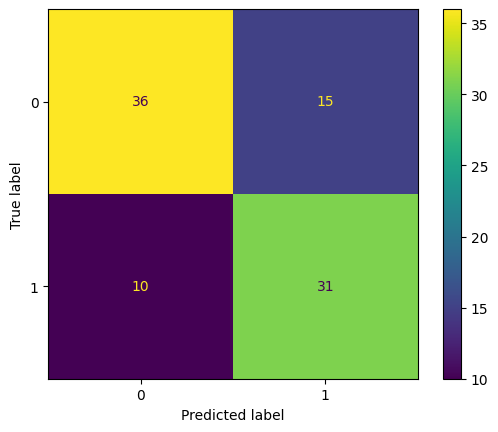

In [4]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenized = data["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

features = last_hidden_states[0][:,0,:].numpy()

train_features, test_features, train_labels, test_labels = train_test_split(features, y)

model = LogisticRegression(class_weight="balanced").fit(train_features, train_labels)
pred = model.predict(test_features)

print('F1 score '+str(f1_score(test_labels, pred)))
print('recall '+str(recall_score(test_labels, pred)))
print('precisao '+str(precision_score(test_labels, pred)))
print('acuracia '+str(accuracy_score(test_labels, pred)))

plot_confusion_matrix(model, test_features, test_labels)
plt.show()

F1 score 0.7209302325581395
recall 0.7560975609756098
precisao 0.6888888888888889
acuracia 0.7391304347826086


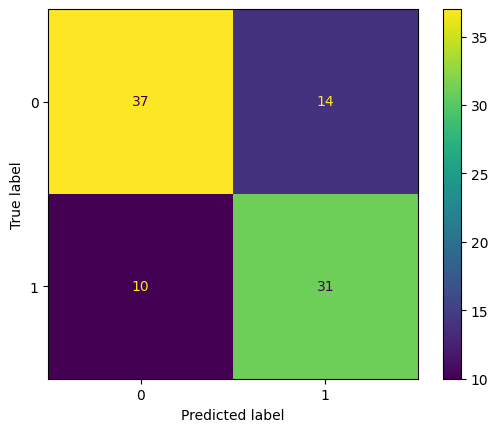

In [5]:
model = GaussianNB().fit(train_features, train_labels)
pred = model.predict(test_features)

print('F1 score '+str(f1_score(test_labels, pred)))
print('recall '+str(recall_score(test_labels, pred)))
print('precisao '+str(precision_score(test_labels, pred)))
print('acuracia '+str(accuracy_score(test_labels, pred)))

plot_confusion_matrix(model, test_features, test_labels)
plt.show()

F1 score 0.6829268292682927
recall 0.6829268292682927
precisao 0.6829268292682927
acuracia 0.717391304347826


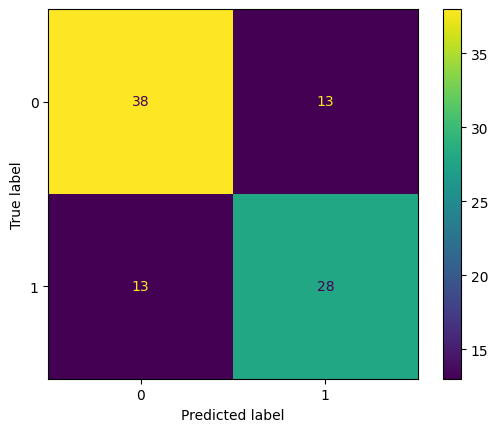

In [6]:
model = svm.SVC(class_weight="balanced").fit(train_features, train_labels)
pred = model.predict(test_features)

print('F1 score '+str(f1_score(test_labels, pred)))
print('recall '+str(recall_score(test_labels, pred)))
print('precisao '+str(precision_score(test_labels, pred)))
print('acuracia '+str(accuracy_score(test_labels, pred)))

plot_confusion_matrix(model, test_features, test_labels)
plt.show()
plt.show()

2. Estude e pesquise sobre o BERTopic, uma adaptação do BERT para modelagem de tópicos. O código fonte está disponível em https://github.com/MaartenGr/BERTopic.<br>
a) Extraia os tópicos de sua base, exibindo as informaçães dos tópicos (palavras mais relevantes).<br>
b) Exiba visualizações com gráficos de barra e usando visualize topics().

In [7]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
data_text = data['text'].reset_index(drop=True)
print(data_text[0])
topics, probs = topic_model.fit_transform(data_text)

freq = topic_model.get_topic_info()
freq.head(5)

leads say using C X ? Because know C fast lots libs available . They might also dislike Java CL . Not every engineering decision perfect lots factors play . Attempts combine best C ( speed ) best scripting languages ( easy things fast without pay attention ) opinion end merely joining worst worlds rather best worlds . The pay attention things needless complexity ( memory management etc ) . They reason put things get speed . If get adequate speed without nobody cares . Besides programming specific ? Do really want code stuff without worry details ? No programming getting results . Nobody cares details level programming language minutuae . We care effort put quality speed results coming ratio .


Batches: 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]
2022-12-05 23:02:32,641 - BERTopic - Transformed documents to Embeddings
2022-12-05 23:02:38,034 - BERTopic - Reduced dimensionality
2022-12-05 23:02:38,072 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,190,-1_the_would_it_one
1,0,60,0_startup_get_people_company
2,1,53,1_language_knowslanguages_speed_code
3,2,26,2_cases_people_botulism_the
4,3,21,3_page_hn_blog_google


In [8]:
topic_model.get_topic(0)

[('startup', 0.03386270418012215),
 ('get', 0.03137602119495036),
 ('people', 0.027242725311095485),
 ('company', 0.026295866648246458),
 ('nt', 0.025192225411235822),
 ('work', 0.023302950024326707),
 ('like', 0.021971078369378613),
 ('time', 0.021700177235551732),
 ('one', 0.021166517888394933),
 ('re', 0.020038534766406435)]

In [9]:
topic_model.visualize_topics()

In [10]:
topic_model.visualize_barchart(top_n_topics=5)